In [27]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from datetime import datetime, date, timedelta
import yfinance as yfin
yfin.pdr_override()


# Graph
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
import matplotlib.pyplot as plt
#import seaborn as sns


# Models
#import arviz as az
#import pymc as pm
import pymc3 as pm
#import xarray as xr
#import bambi as bmb
#from pymc import HalfCauchy, Model, Normal, sample

import warnings

In [28]:
pd.set_option('display.float_format', lambda x: f'{x:,.6f}')
plt.rcParams["figure.figsize"] = (10,6)

#%config InlineBackend.figure_format = 'retina'
#az.style.use("arviz-darkgrid")

#sk.set_config(display='diagram')
warnings.filterwarnings("ignore")

# Assignment: Volatility Forecast 

- Using historical data for an asset in your portfolio develop a 10-day volatility forecast for that asset.
- Post your forecast here
- Upload you code to the GitHub Classroom repository
- Summarize your forecast on a Discussion Board thread


# Variables

In [29]:
start_date = datetime(2022, 1, 1)
purchase_date = datetime(2023, 9, 11)
split_date = datetime(2023,8,24)
today = datetime(2023,11,18)

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)


# Load Portfolio Returns

In [30]:
sp_list = ['ARKK','EXAS','NVTA','PATH','TWLO']

df = pdr.get_data_yahoo(sp_list, start=purchase_date, end=today)['Close']
return_df = df.pct_change().dropna()
print('return_df: ',return_df.shape)

[*********************100%%**********************]  5 of 5 completed
return_df:  (49, 5)


In [31]:
returns = return_df.T.values
print('returns:' , len(returns))

returns: 5


In [32]:
return_mean = np.mean(return_df)
print('return_mean:' , return_mean)

return_mean: -0.0017682457443286173


In [33]:
return_sigma = return_df.std().values[0]
print('return_sigma:' , return_sigma)

return_sigma: 0.026116614933796776


# PyMC3 Model

In [34]:
num_assets = len(sp_list)

# Define the model for portfolio volatility
with pm.Model() as portfolio_model:
    # Prior distributions for asset weights
    w = pm.Dirichlet('weights', a=np.ones(num_assets))
    
    # Expected portfolio return (can be adjusted based on your assumptions)
    mu = pm.Normal('mu', mu=return_mean, sigma=return_sigma)
    portfolio_return = pm.Deterministic('portfolio_return', pm.math.dot(w, [mu] * num_assets))
    
    # Covariance matrix (prior distribution)
    cov_matrix = pm.Lognormal('cov_matrix', mu=np.log(0.01), sigma=0.5, shape=(num_assets, num_assets))
    
    # Portfolio volatility (standard deviation)
    portfolio_volatility = pm.Deterministic('portfolio_volatility', pm.math.sqrt(pm.math.dot(w, pm.math.dot(cov_matrix, w.T))))
    
    # Likelihood (observed data)
    returns_observed = pm.Normal('returns_observed', mu=portfolio_return, sigma=portfolio_volatility, observed=returns)
    
    # Sampling
    trace = pm.sample(2000, tune=1000)
    
    # Forecasting 10 days of volatility using posterior predictive sampling
    future_returns = np.random.normal(0.001, 0.02, size=(10, num_assets))  # Simulated future returns
    future_data = {returns_observed: future_returns}
    
    # Performing posterior predictive sampling for future volatility
    posterior_pred = pm.sample_posterior_predictive(trace, var_names=['portfolio_volatility'], samples=1000, model=portfolio_model)
    
    # Extracting and printing forecasted volatility for the next 10 days
    future_volatility = posterior_pred['portfolio_volatility'][-10]
    print("Forecasted volatility for the next 10 days:")
    print(future_volatility)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cov_matrix, mu, weights]


/Users/dsimbandumwe/anaconda3/envs/pymc3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/dsimbandumwe/anaconda3/envs/pymc3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/dsimbandumwe/anaconda3/envs/pymc3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/dsimbandumwe/anaconda3/envs/pymc3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tunin

Forecasted volatility for the next 10 days:
0.04400689721654491


In [40]:
pred_df = pd.DataFrame(future_returns)
pred_df.columns = sp_list

dti = pd.date_range(max(return_df.index) + pd.DateOffset(1), periods=10, freq="D")
pred_df = pred_df.set_index(dti)
print('pred \n', pred_df[:2])

t_df = pd.concat([return_df[-10:], pred_df], axis=0)
print('t_df: ',t_df.shape)

pred 
                ARKK      EXAS      NVTA      PATH     TWLO
2023-11-18 0.007800 -0.002926 -0.011612 -0.010487 0.015765
2023-11-19 0.010082  0.038873  0.004331  0.003757 0.030393
t_df:  (20, 5)


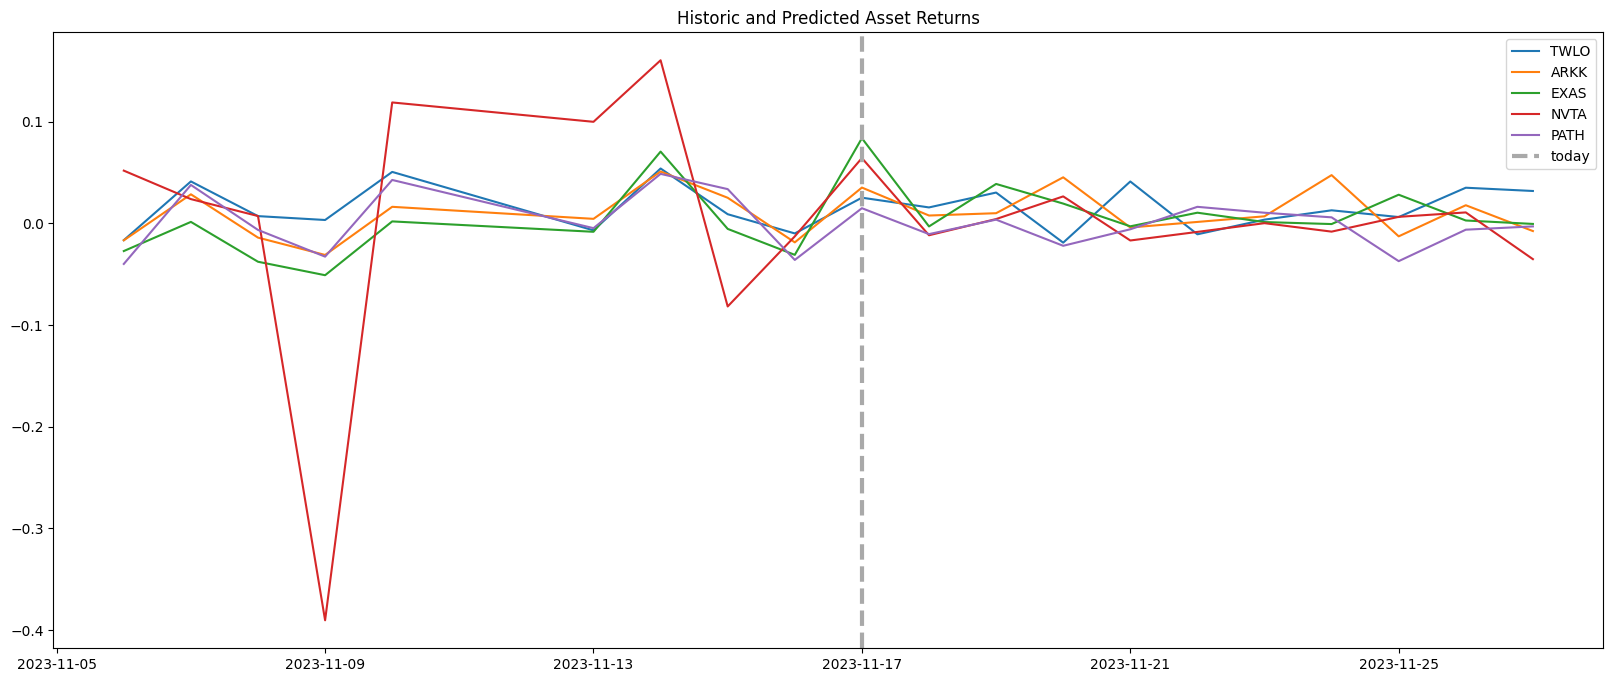

In [36]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

for ticker in set(sp_list):
    plt.plot(t_df.index, t_df[ticker], label=f'{ticker}')
    

plt.axvline(x=max(return_df.index), color='darkgray', linestyle='--', label='today', linewidth=3)


ax.set(title='Historic and Predicted Asset Returns');
plt.legend()
plt.grid(False)
plt.show()